# Project: Wrangle & Analyze Data
---
By Kutloano Molokomme


#### Introduction:   
The dataset I was tasked to wrangle, analyze and visualize is the tweet archive of Twitter user @dog_rates, also known as WeRateDogs. WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. 

#### Goal:   
The goal of the project is to wrangle the 'WeRateDogs' Twitter data to create interesting and trustworthy analyses and visualizations.

#### Data: 
<table style="width: 100%; border: 1px solid; ">
    <tr>
        <th style="width: 20%; text-align: left;">Dataset</th>
        <th style="width: 80%; text-align: left;">Description</th>
    </tr>
    <tr>
        <td style="text-align: left;">Enhanced Twitter Archive</td>
        <td style="text-align: left;">This dataset contains the WeRateDogs tweet data of about +5000 of their tweets.</td>
    </tr>
    <tr>
        <td style="text-align: left;">Image Predictions File</td>
        <td style="text-align: left;">This dataset is made up of image predictions which the team compiled.</td>
    </tr>
    <tr>
        <td style="text-align: left;">Twitter API</td>
        <td style="text-align: left;">Data Access via the Twitter API.</td>
    </tr>    
</table>



#### Table of contents:
<ol>
    <li><a href="#gather">Gather</a>
        <ul style="list-style-type: none;">
            <li>1.1. <a href="#1.1">Gather | Twitter Archive Enchanced</a></li>
            <li>1.2. <a href="#1.2">Gather | Twitter Image Predictions</a></li>
            <li>1.3. <a href="#1.3">Gather | Additional Data via the Twitter API</a></li>
        </ul>
    </li>
    <li><a href="#assess"> Assess</a>
        <ul style="list-style-type: none;">
            <li>2.1. <a href="#2.1">Assess | Twitter Archive Enchanced</a></li>
            <li>2.2. <a href="#2.2">Assess | Twitter Image Predictions</a></li>
            <li>2.3. <a href="#2.3">Assess | Additional Data via the Twitter API</a></li>
        </ul>    
    </li>
    <li><a href="#clean">Clean</a>
        <ul style="list-style-type: none;">
            <li>2.1. <a href="#3.1">Clean | Twitter Archive Enchanced</a></li>
            <li>2.2. <a href="#3.2">Clean | Twitter Image Predictions</a></li>
            <li>2.3. <a href="#3.3">Clean | Additional Data via the Twitter API</a></li>
        </ul>    
    </li>
    <li><a href="#analyse">Analysis &amp; Visualization</a></li>
</ol>

<a id="gather"></a>
## 1. Gather
---

In [27]:
# Import required libraries
import pandas as pd
import requests
import io
import tweepy
import json

<a id="1.1"></a>
### 1.1. Gather | Twitter Archive Enchanced 
The WeRateDogs Twitter archive contains basic tweet data for all 5000+ of their tweets. The data was saved on the 'twitter-archive-enhanced.csv' file.

> For easy navigation I have provided links to wrangling steps performed on the dataset:   
* <a href="#2.1">2.1. Assess | Twitter Archive Enhanced</a>
* <a href="#3.1">3.1. Clean | Twitter Archive Enhanced</a>

In [28]:
# Data: WeRateDogs Twitter archive.
twt_archive = pd.read_csv('twitter-archive-enhanced.csv', encoding='utf-8')

<a id="1.2"></a>
### 1.2. Gather | Twitter Image Predictions
The 'image-predictions.tsv' file contains image predictions alongside each tweet ID, image URL, and the image number that corresponded to the most confident prediction.

>  For easy navigation I have provided links to wrangling steps performed on the dataset: 
* <a href="#2.2">2.2. Assess | Twitter Image Predictions</a>
* <a href="#3.2">3.2. Clean | Twitter Image Predictions</a>

In [29]:
# Data: Tweet Image Prediction
url = 'https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
r = requests.get(url)

twt_images = pd.read_csv(io.StringIO(r.text), sep='\t', encoding='utf-8')

<a id="1.3"></a>
### 1.3. Gather | Additional Data via the Twitter API
Additional data needed for the analysis are to be queried via the Twitter API.

> For easy navigation I have provided links to wrangling steps performed on the dataset:   
* <a href="#2.3">2.3. Assess | Twitter API</a>
* <a href="#3.3">3.3. Clean | Twitter API</a>

In [81]:
# Data: Additional Data via the Twitter API
# Method Reference: https://stackoverflow.com/questions/28384588/twitter-api-get-tweets-with-specific-id
consumer_key = 'YOUR CONSUMER KEY'
consumer_secret = 'YOUR CONSUMER SECRET'
access_token = 'YOUR ACCESS TOKEN'
access_secret = 'YOUR ACCESS SECRET'

auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True, wait_on_rate_limit_notify=True)

In [82]:
%%time
tweet_ids = twt_archive['tweet_id']
tweet = []

for i in tweet_ids:
    try:
        x = api.get_status([i][0], tweet_mode='extended')
    except:
        pass
    
    tweet.append(x._json)

Rate limit reached. Sleeping for: 737
Rate limit reached. Sleeping for: 736
CPU times: user 42.5 s, sys: 2.44 s, total: 44.9 s
Wall time: 31min 50s


In [83]:
# After querying each tweet ID, you will write its JSON data to the required tweet_json.txt file 
# with each tweet's JSON data on its own line.
tweet = json.dumps(tweet)
tweet = pd.read_json(tweet)
tweet.to_json('tweet_json.txt')

In [30]:
twt_api = pd.read_json('tweet_json.txt')

<a id="assess"></a>
## 2. Assess
---

<a id="2.1"></a>
### 2.1. Assess | Twitter Archive Enhanced
> For easy navigation I have provided links to wrangling steps performed on the dataset: 
* <a href="#1.1">1.1. Gather | Twitter Archive Enhanced</a>
* <a href="#3.1">3.1. Clean | Twitter Archive Enhanced</a>

#### Quality:
* Dataset contains retweeted & reply posts with missing values.
* `rating_numerator` & `rating_demonimator` contains some non rating values.
* The `tweet_id fields` datatype is an integer.
* The `timestamp` column is a string.
* The `name` column contains stopwords as dog names.
* The are dog names in the tweet text not assigned to the name column.
* Incorrect dog stage label assigned.
* Two different dog stage labels assigned to the same tweet.



#### Tidiness:
* The `text` fiels contains values with difference casing.
* In variable in 3 columns (`doggo`, `floofer`, `pupper`, `puppo`).

In [181]:
twt_archive.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [182]:
twt_archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
tweet_id                      2356 non-null int64
in_reply_to_status_id         78 non-null float64
in_reply_to_user_id           78 non-null float64
timestamp                     2356 non-null object
source                        2356 non-null object
text                          2356 non-null object
retweeted_status_id           181 non-null float64
retweeted_status_user_id      181 non-null float64
retweeted_status_timestamp    181 non-null object
expanded_urls                 2297 non-null object
rating_numerator              2356 non-null int64
rating_denominator            2356 non-null int64
name                          2356 non-null object
doggo                         2356 non-null object
floofer                       2356 non-null object
pupper                        2356 non-null object
puppo                         2356 non-null object
dtypes: float64(4), int64(3), ob

In [183]:
twt_archive.shape

(2356, 17)

In [184]:
twt_archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [185]:
twt_archive['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [186]:
# Finding Retweets.
twt_archive[twt_archive['text'].str.contains('^RT', regex=True)]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
19,888202515573088257,NaN,NaN,2017-07-21 01:02:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Canela. She attempted s...,8.874740e+17,4.196984e+09,2017-07-19 00:47:34 +0000,https://twitter.com/dog_rates/status/887473957...,13,10,Canela,None,None,None,None
32,886054160059072513,NaN,NaN,2017-07-15 02:45:48 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Athletics: 12/10 #BATP https://t.co/WxwJmv...,8.860537e+17,1.960740e+07,2017-07-15 02:44:07 +0000,https://twitter.com/dog_rates/status/886053434...,12,10,None,None,None,None,None
36,885311592912609280,NaN,NaN,2017-07-13 01:35:06 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Lilly. She just paralle...,8.305833e+17,4.196984e+09,2017-02-12 01:04:29 +0000,https://twitter.com/dog_rates/status/830583320...,13,10,Lilly,None,None,None,None
68,879130579576475649,NaN,NaN,2017-06-26 00:13:58 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Emmy. She was adopted t...,8.780576e+17,4.196984e+09,2017-06-23 01:10:23 +0000,https://twitter.com/dog_rates/status/878057613...,14,10,Emmy,None,None,None,None
73,878404777348136964,NaN,NaN,2017-06-24 00:09:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Shadow. In an attempt to r...,8.782815e+17,4.196984e+09,2017-06-23 16:00:04 +0000,"https://www.gofundme.com/3yd6y1c,https://twitt...",13,10,Shadow,None,None,None,None
74,878316110768087041,NaN,NaN,2017-06-23 18:17:33 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: Meet Terrance. He's being yelle...,6.690004e+17,4.196984e+09,2015-11-24 03:51:38 +0000,https://twitter.com/dog_rates/status/669000397...,11,10,Terrance,None,None,None,None
78,877611172832227328,NaN,NaN,2017-06-21 19:36:23 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @rachel2195: @dog_rates the boyfriend and h...,8.768508e+17,5.128045e+08,2017-06-19 17:14:49 +0000,https://twitter.com/rachel2195/status/87685077...,14,10,None,None,None,pupper,None
91,874434818259525634,NaN,NaN,2017-06-13 01:14:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Coco. At first I though...,8.663350e+17,4.196984e+09,2017-05-21 16:48:45 +0000,https://twitter.com/dog_rates/status/866334964...,12,10,Coco,None,None,None,None
95,873697596434513921,NaN,NaN,2017-06-11 00:25:14 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Walter. He won't start ...,8.688804e+17,4.196984e+09,2017-05-28 17:23:24 +0000,https://twitter.com/dog_rates/status/868880397...,14,10,Walter,None,None,None,None
97,873337748698140672,NaN,NaN,2017-06-10 00:35:19 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @dog_rates: This is Sierra. She's one preci...,8.732138e+17,4.196984e+09,2017-06-09 16:22:42 +0000,https://www.gofundme.com/help-my-baby-sierra-g...,12,10,Sierra,None,None,pupper,None


In [187]:
# Searching for dog stages unassigned.
twt_archive.query("doggo == 'None' & floofer == 'None' & pupper == 'None' & puppo == 'None' ")

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
5,891087950875897856,NaN,NaN,2017-07-29 00:08:17 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a majestic great white breaching ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891087950...,13,10,None,None,None,None,None
6,890971913173991426,NaN,NaN,2017-07-28 16:27:12 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Meet Jax. He enjoys ice cream so much he gets ...,NaN,NaN,NaN,"https://gofundme.com/ydvmve-surgery-for-jax,ht...",13,10,Jax,None,None,None,None
7,890729181411237888,NaN,NaN,2017-07-28 00:22:40 +0000,"<a href=""http://twitter.com/download/iphone"" r...",When you watch your owner call another dog a g...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890729181...,13,10,None,None,None,None,None
8,890609185150312448,NaN,NaN,2017-07-27 16:25:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Zoey. She doesn't want to be one of th...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890609185...,13,10,Zoey,None,None,None,None
10,890006608113172480,NaN,NaN,2017-07-26 00:31:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Koda. He is a South Australian decksha...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/890006608...,13,10,Koda,None,None,None,None


In [188]:
twt_archive['text'].sample(10)

1381    This is Chet. He's dapper af. His owners want ...
430     This is Flash. He went way too hard celebratin...
1943    I know a lot of you are studying for finals. G...
1782    This was Cindy's face when she heard Susan for...
1074    This is Simba. He's the grand prize. The troph...
2134    This is Randall. He's from Chernobyl. Built pl...
1672    Meet Brody. He's a Downton Abbey Falsetto. Add...
1816    *screeches for a sec and then faints* 12/10 ht...
1424    This is Doug. He's a Draconian Jabbawockee. Ra...
1557    When you stumble but recover quickly cause you...
Name: text, dtype: object

<a id="2.2"></a>
### 2.2. Assess | Twitter Image Predictions

>  For easy navigation I have provided links to wrangling steps performed on the dataset: 
* <a href="#2.1">2.1. Gather | Twitter Image Predictions</a>
* <a href="#3.2">3.2. Clean | Twitter Image Predictions</a>

#### Quality:
* There are only 2075 items listed our Archive dataset is made up of 2356.
* `tweet_id` has a data type of interger when it should a string.
* `jpg_url` has duplicate image urls. 

#### Tidiness:
* `p1`, `p2`, `p3` columns values are in title & lowercase. 

In [189]:
twt_images.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [190]:
twt_images.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null int64
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [191]:
twt_images.shape

(2075, 12)

In [192]:
twt_images[twt_images['jpg_url'].duplicated() == True].sample(10)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1615,802247111496568832,https://pbs.twimg.com/media/Cs_DYr1XEAA54Pu.jpg,1,Chihuahua,0.721188,True,toy_terrier,0.112943,True,kelpie,0.053365,True
1636,806242860592926720,https://pbs.twimg.com/media/Ct72q9jWcAAhlnw.jpg,2,Cardigan,0.593858,True,Shetland_sheepdog,0.130611,True,Pembroke,0.100842,True
1446,775898661951791106,https://pbs.twimg.com/media/CiyHLocU4AI2pJu.jpg,1,golden_retriever,0.945523,True,Labrador_retriever,0.042319,True,doormat,0.003956,False
1944,861769973181624320,https://pbs.twimg.com/media/CzG425nWgAAnP7P.jpg,2,Arabian_camel,0.366248,False,house_finch,0.209852,False,cocker_spaniel,0.046403,True
1645,808134635716833280,https://pbs.twimg.com/media/Cx5R8wPVEAALa9r.jpg,1,cocker_spaniel,0.740220,True,Dandie_Dinmont,0.061604,True,English_setter,0.041331,True
1652,809808892968534016,https://pbs.twimg.com/media/CwS4aqZXUAAe3IO.jpg,1,Labrador_retriever,0.861651,True,golden_retriever,0.044462,True,Staffordshire_bullterrier,0.016497,True
1453,776819012571455488,https://pbs.twimg.com/media/CW88XN4WsAAlo8r.jpg,3,Chihuahua,0.346545,True,dalmatian,0.166246,True,toy_terrier,0.117502,True
1591,798665375516884993,https://pbs.twimg.com/media/CVMOlMiWwAA4Yxl.jpg,1,chow,0.243529,True,hamster,0.227150,False,Pomeranian,0.056057,True
1297,752309394570878976,https://pbs.twimg.com/ext_tw_video_thumb/67535...,1,upright,0.303415,False,golden_retriever,0.181351,True,Brittany_spaniel,0.162084,True
1605,800443802682937345,https://pbs.twimg.com/media/CsVO7ljW8AAckRD.jpg,1,mousetrap,0.777468,False,black_widow,0.093940,False,paddlewheel,0.017492,False


<a id="2.3"></a>
### 2.3. Assess | Additional Data via the Twitter API

> For easy navigation I have provided links to wrangling steps performed on the dataset:   
* <a href="#1.3">1.3. Gather | Twitter API</a>
* <a href="#3.3">3.3. Clean | Twitter API</a>

#### Quality:
* Columns values are NaN.   
Column: **contributors**; **coordinates**; **geo** 


* Column values are in json format   
Column: **entities**; **extended_entities**; **user**   


* Values are duplicated   
Column: **user**

#### Tidiness:

In [193]:
twt_api.head()

,contributors,coordinates,created_at,display_text_range,entities,extended_entities,favorite_count,favorited,full_text,geo,...,quoted_status,quoted_status_id,quoted_status_id_str,quoted_status_permalink,retweet_count,retweeted,retweeted_status,source,truncated,user
0,NaN,NaN,2017-08-01 16:23:56,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892420639486877696, 'id_str'...",35168,False,This is Phineas. He's a mystical boy. Only eve...,NaN,...,None,NaN,NaN,None,7421,False,None,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1,NaN,NaN,2017-08-01 00:17:27,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 892177413194625024, 'id_str'...",30437,False,This is Tilly. She's just checking pup on you....,NaN,...,None,NaN,NaN,None,5518,False,None,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
10,NaN,NaN,2017-07-26 00:31:25,"[0, 130]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...","{'media': [{'id': 890006600089468928, 'id_str'...",28039,False,This is Koda. He is a South Australian decksha...,NaN,...,None,NaN,NaN,None,6451,False,None,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
100,NaN,NaN,2017-06-08 14:20:41,"[0, 140]",{'hashtags': [{'text': 'dogsatpollingstations'...,"{'media': [{'id': 872820673743376386, 'id_str'...",13562,False,Here are my favorite #dogsatpollingstations \n...,NaN,...,None,NaN,NaN,None,3306,False,None,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1000,NaN,NaN,2016-06-29 01:23:16,"[0, 70]","{'hashtags': [], 'symbols': [], 'user_mentions...","{'media': [{'id': 747963600220917761, 'id_str'...",5618,False,PUPPER NOOOOO BEHIND YOUUU 10/10 pls keep this...,NaN,...,None,NaN,NaN,None,2076,False,None,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


In [194]:
twt_api.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 999
Data columns (total 32 columns):
contributors                     0 non-null float64
coordinates                      0 non-null float64
created_at                       2356 non-null datetime64[ns]
display_text_range               2356 non-null object
entities                         2356 non-null object
extended_entities                2082 non-null object
favorite_count                   2356 non-null int64
favorited                        2356 non-null bool
full_text                        2356 non-null object
geo                              0 non-null float64
id                               2356 non-null int64
id_str                           2356 non-null int64
in_reply_to_screen_name          78 non-null object
in_reply_to_status_id            78 non-null float64
in_reply_to_status_id_str        78 non-null float64
in_reply_to_user_id              78 non-null float64
in_reply_to_user_id_str          78 no

In [195]:
twt_api['extended_entities'][10]

{'media': [{'id': 890006600089468928,
   'id_str': '890006600089468928',
   'indices': [131, 154],
   'media_url': 'http://pbs.twimg.com/media/DFnwSY4WAAAMliS.jpg',
   'media_url_https': 'https://pbs.twimg.com/media/DFnwSY4WAAAMliS.jpg',
   'url': 'https://t.co/dVPW0B0Mme',
   'display_url': 'pic.twitter.com/dVPW0B0Mme',
   'expanded_url': 'https://twitter.com/dog_rates/status/890006608113172480/photo/1',
   'type': 'photo',
   'sizes': {'medium': {'w': 1200, 'h': 1199, 'resize': 'fit'},
    'thumb': {'w': 150, 'h': 150, 'resize': 'crop'},
    'small': {'w': 680, 'h': 680, 'resize': 'fit'},
    'large': {'w': 1601, 'h': 1600, 'resize': 'fit'}}},
  {'id': 890006600093753345,
   'id_str': '890006600093753345',
   'indices': [131, 154],
   'media_url': 'http://pbs.twimg.com/media/DFnwSY5XYAEwtc5.jpg',
   'media_url_https': 'https://pbs.twimg.com/media/DFnwSY5XYAEwtc5.jpg',
   'url': 'https://t.co/dVPW0B0Mme',
   'display_url': 'pic.twitter.com/dVPW0B0Mme',
   'expanded_url': 'https://twit

In [196]:
twt_api['entities'][10]

{'hashtags': [{'text': 'BarkWeek', 'indices': [121, 130]}],
 'symbols': [],
 'user_mentions': [],
 'urls': [],
 'media': [{'id': 890006600089468928,
   'id_str': '890006600089468928',
   'indices': [131, 154],
   'media_url': 'http://pbs.twimg.com/media/DFnwSY4WAAAMliS.jpg',
   'media_url_https': 'https://pbs.twimg.com/media/DFnwSY4WAAAMliS.jpg',
   'url': 'https://t.co/dVPW0B0Mme',
   'display_url': 'pic.twitter.com/dVPW0B0Mme',
   'expanded_url': 'https://twitter.com/dog_rates/status/890006608113172480/photo/1',
   'type': 'photo',
   'sizes': {'medium': {'w': 1200, 'h': 1199, 'resize': 'fit'},
    'thumb': {'w': 150, 'h': 150, 'resize': 'crop'},
    'small': {'w': 680, 'h': 680, 'resize': 'fit'},
    'large': {'w': 1601, 'h': 1600, 'resize': 'fit'}}}]}

In [197]:
twt_api['possibly_sensitive'].value_counts()

0.0    2221
Name: possibly_sensitive, dtype: int64

<a id="clean"></a>
## 3. Clean
---

In [31]:
twt_archive_clean = twt_archive.copy()
twt_images_clean = twt_images.copy()
twt_api_clean = twt_api.copy()

<a id="3.1"></a>
### 3.1. Clean | Twitter Archive Enhanced
---

> For easy navigation I have provided links to wrangling steps performed on the dataset: 
* <a href="#1.1">1.1. Gather | Twitter Archive Enhanced</a>
* <a href="#2.1">2.1. Assess | Twitter Archive Enhanced</a>

#### Quality - Assess: 
Dataset contains retweeted & reply posts.

####  3.1.1. Define
Remove retweet & reply post rows from the dataset using the drop method and drop corresponding columns.

In [199]:
# Code:
# Remove Retweet Post rows.
twt_archive_clean = twt_archive_clean.drop(twt_archive_clean.query('retweeted_status_id != "NaN" or in_reply_to_status_id != "NaN"').index)
twt_archive_clean = twt_archive_clean.reset_index(drop=True)

In [200]:
# Test:
print("Check Retweet & Reply Rows including corresponding Columns for the removed data.")
print("retweeted_status_id: ", len(twt_archive_clean.query('retweeted_status_id != "NaN"')))
print("retweeted_status_user_id: ", len(twt_archive_clean.query('retweeted_status_user_id != "NaN"')))
print("in_reply_to_status_id", len(twt_archive_clean.query('in_reply_to_status_id != "NaN"')))
print("in_reply_to_status_id", len(twt_archive_clean.query('retweeted_status_user_id != "NaN"')))

Check Retweet & Reply Rows including corresponding Columns for the removed data.
retweeted_status_id:  0
retweeted_status_user_id:  0
in_reply_to_status_id 0
in_reply_to_status_id 0


#### 3.1.2. Define
Remove columns in the dataset as they are included in and can be inferred from the twt_api dataset.

In [201]:
# Code:
# Drop Retweet & Repost Columns:
twt_archive_clean = twt_archive_clean.drop(columns=[
                                            'in_reply_to_status_id',
                                            'in_reply_to_user_id', 
                                            'retweeted_status_id', 
                                            'retweeted_status_user_id', 
                                            'retweeted_status_timestamp',
                                            'source',
                                            'expanded_urls']
                                          )
twt_archive_clean = twt_archive_clean.reset_index(drop=True)

In [202]:
# Test:
twt_archive_clean.head()

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,None,None,None,None
1,892177421306343426,2017-08-01 00:17:27 +0000,This is Tilly. She's just checking pup on you....,13,10,Tilly,None,None,None,None
2,891815181378084864,2017-07-31 00:18:03 +0000,This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,None,None,None,None
3,891689557279858688,2017-07-30 15:58:51 +0000,This is Darla. She commenced a snooze mid meal...,13,10,Darla,None,None,None,None
4,891327558926688256,2017-07-29 16:00:24 +0000,This is Franklin. He would like you to stop ca...,12,10,Franklin,None,None,None,None


#### Quality - Assess:
rating_numerator & rating_demonimator contains some non rating values.

#### 3.1.3. Define:
Re-extract the rating_numerator & denominator from the tweet text as the initial extraction incorrectly matched the following as rating scores:
* measurement (e.g. 1/2)
* all hours, whole week shortform (e.g. 24/7)
* dates (e.g. 9/11, 4/20)
* store (e.g. 7/11)

In [203]:
# Code:
# Re-extract the rating_numerator & denominator from the tweet text. 
twt_archive_clean['rating'] = twt_archive_clean['text'].str.extract(r'(\d\d/10|\d/10)')[0]
twt_archive_clean['rating_numerator'], twt_archive_clean['rating_denominator'] = twt_archive_clean['rating'].str.split('/', 1).str

In [204]:
# Test:
twt_archive_clean.head()

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,rating
0,892420643555336193,2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,None,None,None,None,13/10
1,892177421306343426,2017-08-01 00:17:27 +0000,This is Tilly. She's just checking pup on you....,13,10,Tilly,None,None,None,None,13/10
2,891815181378084864,2017-07-31 00:18:03 +0000,This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,None,None,None,None,12/10
3,891689557279858688,2017-07-30 15:58:51 +0000,This is Darla. She commenced a snooze mid meal...,13,10,Darla,None,None,None,None,13/10
4,891327558926688256,2017-07-29 16:00:24 +0000,This is Franklin. He would like you to stop ca...,12,10,Franklin,None,None,None,None,12/10


#### 3.1.4. Define:
Remove rows where rating returns NaN as these do not contain the denominator set for rating single dog. 
The text were the denominator is more than 10, mentions more than one dog being scored.

In [205]:
# Code:
twt_archive_clean = twt_archive_clean.drop(twt_archive_clean[twt_archive_clean['rating'].isnull()].index)
twt_archive_clean = twt_archive_clean.reset_index(drop=True)

# Convert string value to integer
twt_archive_clean['rating_numerator'] = twt_archive_clean['rating_numerator'].astype(int)
twt_archive_clean['rating_denominator'] = twt_archive_clean['rating_denominator'].astype(int)

In [206]:
# Test:
twt_archive_clean.head()

,tweet_id,timestamp,text,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,rating
0,892420643555336193,2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only eve...,13,10,Phineas,None,None,None,None,13/10
1,892177421306343426,2017-08-01 00:17:27 +0000,This is Tilly. She's just checking pup on you....,13,10,Tilly,None,None,None,None,13/10
2,891815181378084864,2017-07-31 00:18:03 +0000,This is Archie. He is a rare Norwegian Pouncin...,12,10,Archie,None,None,None,None,12/10
3,891689557279858688,2017-07-30 15:58:51 +0000,This is Darla. She commenced a snooze mid meal...,13,10,Darla,None,None,None,None,13/10
4,891327558926688256,2017-07-29 16:00:24 +0000,This is Franklin. He would like you to stop ca...,12,10,Franklin,None,None,None,None,12/10


In [207]:
twt_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2085 entries, 0 to 2084
Data columns (total 11 columns):
tweet_id              2085 non-null int64
timestamp             2085 non-null object
text                  2085 non-null object
rating_numerator      2085 non-null int64
rating_denominator    2085 non-null int64
name                  2085 non-null object
doggo                 2085 non-null object
floofer               2085 non-null object
pupper                2085 non-null object
puppo                 2085 non-null object
rating                2085 non-null object
dtypes: int64(3), object(8)
memory usage: 179.3+ KB


#### 3.1.5. Define
Repurpose the rating column to hold the singular value.

In [208]:
# Code:
twt_archive_clean['rating'] = twt_archive_clean['rating_numerator'] / twt_archive_clean['rating_denominator']
twt_archive_clean = twt_archive_clean.drop(columns=['rating_numerator', 'rating_denominator'])

In [209]:
# Test:
twt_archive_clean.head()

,tweet_id,timestamp,text,name,doggo,floofer,pupper,puppo,rating
0,892420643555336193,2017-08-01 16:23:56 +0000,This is Phineas. He's a mystical boy. Only eve...,Phineas,None,None,None,None,1.3
1,892177421306343426,2017-08-01 00:17:27 +0000,This is Tilly. She's just checking pup on you....,Tilly,None,None,None,None,1.3
2,891815181378084864,2017-07-31 00:18:03 +0000,This is Archie. He is a rare Norwegian Pouncin...,Archie,None,None,None,None,1.2
3,891689557279858688,2017-07-30 15:58:51 +0000,This is Darla. She commenced a snooze mid meal...,Darla,None,None,None,None,1.3
4,891327558926688256,2017-07-29 16:00:24 +0000,This is Franklin. He would like you to stop ca...,Franklin,None,None,None,None,1.2


#### Quality - Assesss
The tweet_id fields datatype is an integer.

#### 3.1.6. Define
Convert tweet_id column from an interger datatype to a string.

In [210]:
# Code:
# Convert tweet_id from interger to string
twt_archive_clean['tweet_id'] = twt_archive_clean.tweet_id.astype(str)

In [211]:
# Test:
twt_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2085 entries, 0 to 2084
Data columns (total 9 columns):
tweet_id     2085 non-null object
timestamp    2085 non-null object
text         2085 non-null object
name         2085 non-null object
doggo        2085 non-null object
floofer      2085 non-null object
pupper       2085 non-null object
puppo        2085 non-null object
rating       2085 non-null float64
dtypes: float64(1), object(8)
memory usage: 146.7+ KB


#### Quality - Assess
The timestamp column is a string.

#### 3.1.7. Define
Convert timestamp from object datatype to the timestamp datatype.

In [212]:
# Convert timestamp datatype to timestamp
twt_archive_clean['timestamp'] = pd.to_datetime(twt_archive_clean['timestamp'])

In [213]:
twt_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2085 entries, 0 to 2084
Data columns (total 9 columns):
tweet_id     2085 non-null object
timestamp    2085 non-null datetime64[ns]
text         2085 non-null object
name         2085 non-null object
doggo        2085 non-null object
floofer      2085 non-null object
pupper       2085 non-null object
puppo        2085 non-null object
rating       2085 non-null float64
dtypes: datetime64[ns](1), float64(1), object(7)
memory usage: 146.7+ KB


#### Tidiness - Assess
The text fiels contains values with difference casing.

#### 3.1.8. Define
For consistency convert text column to lowercase

In [214]:
# Code:
# Convert text to lower case & remove newline
twt_archive_clean['text'] = twt_archive_clean['text'].str.lower()
twt_archive_clean['text'] = twt_archive_clean['text'].str.strip()

# https://www.codegrepper.com/code-examples/python/removing+new+line+character+in+python+from+dataframe
twt_archive_clean.replace(to_replace=[r"\\t|\\n|\\r", "\t|\n|\r"], value=["",""], regex=True, inplace=True)

In [215]:
# Test:
twt_archive_clean.head()

,tweet_id,timestamp,text,name,doggo,floofer,pupper,puppo,rating
0,892420643555336193,2017-08-01 16:23:56,this is phineas. he's a mystical boy. only eve...,Phineas,None,None,None,None,1.3
1,892177421306343426,2017-08-01 00:17:27,this is tilly. she's just checking pup on you....,Tilly,None,None,None,None,1.3
2,891815181378084864,2017-07-31 00:18:03,this is archie. he is a rare norwegian pouncin...,Archie,None,None,None,None,1.2
3,891689557279858688,2017-07-30 15:58:51,this is darla. she commenced a snooze mid meal...,Darla,None,None,None,None,1.3
4,891327558926688256,2017-07-29 16:00:24,this is franklin. he would like you to stop ca...,Franklin,None,None,None,None,1.2


#### Quality - Assess
The name column contains stopwords as dog names

#### 3.1.9. Define
Make changes to the values in the name column as the intially extraction errornously extracted stop words as the names of the dog. For value that are stop words change to None.

In [216]:
# Code:
stop_word_names = twt_archive_clean[twt_archive_clean['name'].str.contains(r'^[a-z]+$', regex=True)]
stop_word_names = stop_word_names['name'].value_counts()
stop_word_names = stop_word_names.index.tolist()

for i in stop_word_names:
    twt_archive_clean['name'] = twt_archive_clean['name'].replace(i, "None")

In [217]:
# Test:
twt_archive_clean.head(10)

,tweet_id,timestamp,text,name,doggo,floofer,pupper,puppo,rating
0,892420643555336193,2017-08-01 16:23:56,this is phineas. he's a mystical boy. only eve...,Phineas,None,None,None,None,1.3
1,892177421306343426,2017-08-01 00:17:27,this is tilly. she's just checking pup on you....,Tilly,None,None,None,None,1.3
2,891815181378084864,2017-07-31 00:18:03,this is archie. he is a rare norwegian pouncin...,Archie,None,None,None,None,1.2
3,891689557279858688,2017-07-30 15:58:51,this is darla. she commenced a snooze mid meal...,Darla,None,None,None,None,1.3
4,891327558926688256,2017-07-29 16:00:24,this is franklin. he would like you to stop ca...,Franklin,None,None,None,None,1.2
5,891087950875897856,2017-07-29 00:08:17,here we have a majestic great white breaching ...,None,None,None,None,None,1.3
6,890971913173991426,2017-07-28 16:27:12,meet jax. he enjoys ice cream so much he gets ...,Jax,None,None,None,None,1.3
7,890729181411237888,2017-07-28 00:22:40,when you watch your owner call another dog a g...,None,None,None,None,None,1.3
8,890609185150312448,2017-07-27 16:25:51,this is zoey. she doesn't want to be one of th...,Zoey,None,None,None,None,1.3
9,890240255349198849,2017-07-26 15:59:51,this is cassie. she is a college pup. studying...,Cassie,doggo,None,None,None,1.4


#### Quality - Assess:
The are dog names in the tweet text not assigned to the name column.

#### 3.1.10 Define
Using regex find additional dog names from the tweet texts and add to the name column.

In [218]:
# Code:
# Extract names following the "named ..." sequence in the tweet text.
twt_archive_clean['new_name'] = twt_archive_clean.query('name == "None"')['text'].str.extract(r'named ([a-z]+)')
twt_archive_clean['new_name'] = twt_archive_clean['new_name'].str.title()
twt_archive_clean.loc[twt_archive_clean['name'] == "None", 'name'] = twt_archive_clean['new_name']

In [219]:
# Code:
# Extract names following the "name is ..." sequence in the tweet text.
twt_archive_clean['new_name'] = twt_archive_clean.query('name == "None"')['text'].str.extract(r'name is ([a-z]+)')
twt_archive_clean['new_name'] = twt_archive_clean['new_name'].str.title()
twt_archive_clean.loc[twt_archive_clean['name'] == "None", 'name'] = twt_archive_clean['new_name']

In [220]:
twt_archive_clean = twt_archive_clean.drop(columns='new_name')

In [221]:
# Test:
twt_archive_clean.head()

,tweet_id,timestamp,text,name,doggo,floofer,pupper,puppo,rating
0,892420643555336193,2017-08-01 16:23:56,this is phineas. he's a mystical boy. only eve...,Phineas,None,None,None,None,1.3
1,892177421306343426,2017-08-01 00:17:27,this is tilly. she's just checking pup on you....,Tilly,None,None,None,None,1.3
2,891815181378084864,2017-07-31 00:18:03,this is archie. he is a rare norwegian pouncin...,Archie,None,None,None,None,1.2
3,891689557279858688,2017-07-30 15:58:51,this is darla. she commenced a snooze mid meal...,Darla,None,None,None,None,1.3
4,891327558926688256,2017-07-29 16:00:24,this is franklin. he would like you to stop ca...,Franklin,None,None,None,None,1.2


#### Tidiness - Asesss:
In variable in 3 columns (doggo, floofer, pupper, puppo)

#### 3.1.11. Define
Melt the dog stage columns (doggo, floofer, pupper & puppo) to dog stage column.

In [222]:
# Code:
# Create a new column containing the label 'unassigned' for dogs that do not have stage assigned.
twt_archive_clean['unassigned'] = twt_archive_clean['doggo'] + twt_archive_clean['floofer'] + twt_archive_clean['pupper'] + twt_archive_clean['puppo']

# Reference to solution used:
# https://www.kite.com/python/answers/how-to-change-values-in-a-pandas-dataframe-column-based-on-a-condition-in-python#
twt_archive_clean.loc[twt_archive_clean['unassigned'] == "NoneNoneNoneNone", 'unassigned'] = 'unassigned'
twt_archive_clean.loc[twt_archive_clean['unassigned'] != 'unassigned', 'unassigned'] = 'assigned'

In [223]:
# Code:
twt_archive_clean = pd.melt(
                            twt_archive_clean, 
                            id_vars=['tweet_id','timestamp', 'text', 'name', 'rating'],
                            var_name='dog_stage', value_name='allocation'
                           )
twt_archive_clean = twt_archive_clean.drop(twt_archive_clean.query('allocation == "None"').index)
twt_archive_clean = twt_archive_clean.drop(columns='allocation')
twt_archive_clean = twt_archive_clean.reset_index(drop=True)

In [224]:
# Test:
twt_archive_clean.head()

,tweet_id,timestamp,text,name,rating,dog_stage
0,890240255349198849,2017-07-26 15:59:51,this is cassie. she is a college pup. studying...,Cassie,1.4,doggo
1,884162670584377345,2017-07-09 21:29:42,meet yogi. he doesn't have any important dog m...,Yogi,1.2,doggo
2,872967104147763200,2017-06-09 00:02:31,here's a very large dog. he has a date later. ...,NaN,1.2,doggo
3,871515927908634625,2017-06-04 23:56:03,this is napolean. he's a raggedy east nicaragu...,Napolean,1.2,doggo
4,871102520638267392,2017-06-03 20:33:19,never doubt a doggo 14/10 https://t.co/abblh2fzch,NaN,1.4,doggo


In [225]:
# Test:
twt_archive_clean.shape

(2432, 6)

#### Quality - Assess:
Incorrect dog stage label assigned.

#### 3.1.12. Define
Assign the correct dog stage label found in the items text field.

In [226]:
# Code:
# Replace unassigned dog_stage items if the dog_stage label is mentioned in their associated text.
dog_stage = ['doggo', 'floofer', 'puppo', 'pupper']

for label in dog_stage:
    twt_archive_clean.loc[twt_archive_clean['text'].str.contains(r'\b%s\b' % dog_stage, regex=True), 'dog_stage'] = twt_archive_clean['dog_stage'].replace("unassigned", label)

In [227]:
# Test:
print("check instances were the dog label is allocated & the dog_stage value is set to unassigned: ")
dog_stage = ['doggo', 'floofer', 'puppo', 'pupper']
for i in dog_stage:
    print('"%s" dog_stage = unassigned: ' % i, len(twt_archive_clean.loc[twt_archive_clean['text'].str.contains(i)].query('dog_stage == "unassigned"')))

check instances were the dog label is allocated & the dog_stage value is set to unassigned: 
"doggo" dog_stage = unassigned:  0
"floofer" dog_stage = unassigned:  0
"puppo" dog_stage = unassigned:  0
"pupper" dog_stage = unassigned:  0


#### Quality - Assess:
Two different dog stage labels assigned to the same tweet.

#### 3.1.13. Define
Remove Items where the tweet text contains 2 dog stage labels.

In [228]:
#Code:
twt_archive_clean = twt_archive_clean.drop(twt_archive_clean[(twt_archive_clean['text'].str.contains(r'\bdoggo\b', regex=True)) & (twt_archive_clean['text'].str.contains(r'\bfloofer\b|\bpupper\b|\bpuppo\b', regex=True))].index)
twt_archive_clean = twt_archive_clean.drop(twt_archive_clean[(twt_archive_clean['text'].str.contains(r'\bfloofer\b', regex=True)) & (twt_archive_clean['text'].str.contains(r'\bdoggo\b|\bpupper\b|\bpuppo\b', regex=True))].index)
twt_archive_clean = twt_archive_clean.drop(twt_archive_clean[(twt_archive_clean['text'].str.contains(r'\bpupper\b', regex=True)) & (twt_archive_clean['text'].str.contains(r'\bfloofer\b|\bdoggo\b|\bpuppo\b', regex=True))].index)
twt_archive_clean = twt_archive_clean.drop(twt_archive_clean[(twt_archive_clean['text'].str.contains(r'\bpuppo\b', regex=True)) & (twt_archive_clean['text'].str.contains(r'\bfloofer\b|\bdoggo\b|\bpupper\b', regex=True))].index)

In [229]:
# Test:
doggo_paired = twt_archive_clean[(twt_archive_clean['text'].str.contains(r'\bdoggo\b', regex=True)) & (twt_archive_clean['text'].str.contains(r'\bfloofer\b|\bpupper\b|\bpuppo\b', regex=True))]
floofer_paired = twt_archive_clean[(twt_archive_clean['text'].str.contains(r'\bfloofer\b', regex=True)) & (twt_archive_clean['text'].str.contains(r'\bdoggo\b|\bpupper\b|\bpuppo\b', regex=True))]
pupper_paired = twt_archive_clean[(twt_archive_clean['text'].str.contains(r'\bpupper\b', regex=True)) & (twt_archive_clean['text'].str.contains(r'\bfloofer\b|\bdoggo\b|\bpuppo\b', regex=True))]
puppo_paired = twt_archive_clean[(twt_archive_clean['text'].str.contains(r'\bpuppo\b', regex=True)) & (twt_archive_clean['text'].str.contains(r'\bfloofer\b|\bdoggo\b|\bpupper\b', regex=True))]

print('Doggo Paired: ', len(doggo_paired))
print('Floofer Paired: ', len(floofer_paired))
print('Pupper Paired: ', len(pupper_paired))
print('Puppo Paired: ', len(puppo_paired))
print(len)

Doggo Paired:  0
Floofer Paired:  0
Pupper Paired:  0
Puppo Paired:  0
<built-in function len>


#### 3.1.15. Define
Delete duplicated rows.

In [230]:
# Code:
# Delete duplicate items
twt_archive_clean = twt_archive_clean.drop_duplicates(subset=['tweet_id'])
twt_archive_clean = twt_archive_clean.reset_index(drop=True)

In [231]:
# Test:
twt_archive_clean[twt_archive_clean['tweet_id'].duplicated() == True]

,tweet_id,timestamp,text,name,rating,dog_stage


In [232]:
# Test:
twt_archive_clean.head()

,tweet_id,timestamp,text,name,rating,dog_stage
0,890240255349198849,2017-07-26 15:59:51,this is cassie. she is a college pup. studying...,Cassie,1.4,doggo
1,884162670584377345,2017-07-09 21:29:42,meet yogi. he doesn't have any important dog m...,Yogi,1.2,doggo
2,872967104147763200,2017-06-09 00:02:31,here's a very large dog. he has a date later. ...,NaN,1.2,doggo
3,871515927908634625,2017-06-04 23:56:03,this is napolean. he's a raggedy east nicaragu...,Napolean,1.2,doggo
4,871102520638267392,2017-06-03 20:33:19,never doubt a doggo 14/10 https://t.co/abblh2fzch,NaN,1.4,doggo


In [233]:
twt_archive_clean.shape

(2075, 6)

In [234]:
twt_archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 6 columns):
tweet_id     2075 non-null object
timestamp    2075 non-null datetime64[ns]
text         2075 non-null object
name         1409 non-null object
rating       2075 non-null float64
dog_stage    2075 non-null object
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 97.3+ KB


#### 3.1.16. Define
Remove URLs from tweet text.

In [235]:
twt_archive_clean['text'] = twt_archive_clean['text'].replace(regex=r'(https\:.*.)', value='')
twt_archive_clean['text'] = twt_archive_clean['text'].str.strip()

In [236]:
twt_archive_clean['text'].sample(10)

899     this is luna. she's just heckin precious af i ...
203     this is lucy. she's terrified of the stuffed b...
695     this is peaches. she's the ultimate selfie sid...
1971    this is a shotokon macadamia mix named cheryl....
741     this is mosby. he appears to be rather h*ckin ...
1522    meet sammy. at first i was like "that's a snow...
692     this is milo. i would do terrible things for m...
1373    this is buddy. he's testing out the water. suc...
711     this is daisy. she's here to make your day bet...
300     this is rolf. he's having the time of his life...
Name: text, dtype: object

<a id="3.2"></a>
### 3.2. Clean | Twitter Image Predictions
---
>For easy navigation I have provided links to wrangling steps performed on the dataset below:   
* <a href="#1.2">1.3. Gather | Twitter Image Predictions</a>
* <a href="#2.2">2.3. Assess | Twitter Image Predictions</a>

#### Quality - Assess:
`tweet_id` has a data type of interger when it should a string.

#### 3.2.1. Define
Convert tweet_id column from an interger datatype to a string.

In [237]:
# Convert tweet_id from interger to string
twt_images_clean['tweet_id'] = twt_images_clean.tweet_id.astype(str)

In [238]:
# Test:
twt_images_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
tweet_id    2075 non-null object
jpg_url     2075 non-null object
img_num     2075 non-null int64
p1          2075 non-null object
p1_conf     2075 non-null float64
p1_dog      2075 non-null bool
p2          2075 non-null object
p2_conf     2075 non-null float64
p2_dog      2075 non-null bool
p3          2075 non-null object
p3_conf     2075 non-null float64
p3_dog      2075 non-null bool
dtypes: bool(3), float64(3), int64(1), object(5)
memory usage: 152.1+ KB


#### Tidiness - Assess:
`p1`, `p2`, `p3` columns values are in title & lowercase. 

#### Define
Change all values to title case & remove underscore from labels for consistency.

In [239]:
# Code
cols = ['p1','p2','p3'] 

for col in cols:
    twt_images_clean[col] = twt_images_clean[col].str.title()
    twt_images_clean[col] = twt_images_clean[col].str.replace('_', ' ')

In [240]:
# Test:
twt_images_clean.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh Springer Spaniel,0.465074,True,Collie,0.156665,True,Shetland Sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,Redbone,0.506826,True,Miniature Pinscher,0.074192,True,Rhodesian Ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German Shepherd,0.596461,True,Malinois,0.138584,True,Bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian Ridgeback,0.408143,True,Redbone,0.360687,True,Miniature Pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,Miniature Pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


#### Define
Filter dataframe to only match ids in the archive dataframe.

In [241]:
m = twt_images_clean.tweet_id.isin(twt_archive_clean.tweet_id)
twt_images_clean = twt_images_clean[m]

In [242]:
twt_images_clean.shape

(1950, 12)

<a id="3.3"></a>
### 3.3. Clean | Additional Data via the Twitter API
> For easy navigation I have provided links to wrangling steps performed on the dataset below:   
* <a href="#1.3">1.3. Gather | Twitter API</a>
* <a href="#2.3">2.3. Assess | Twitter API</a>

#### Define
Rename columns entities similar to the archive dataframe.

In [243]:
# Code:
twt_api_clean = twt_api_clean.rename(columns={'created_at': 'timestamp', 'id': 'tweet_id'})

In [244]:
# Test:
twt_api_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2356 entries, 0 to 999
Data columns (total 32 columns):
contributors                     0 non-null float64
coordinates                      0 non-null float64
timestamp                        2356 non-null datetime64[ns]
display_text_range               2356 non-null object
entities                         2356 non-null object
extended_entities                2082 non-null object
favorite_count                   2356 non-null int64
favorited                        2356 non-null bool
full_text                        2356 non-null object
geo                              0 non-null float64
tweet_id                         2356 non-null int64
id_str                           2356 non-null int64
in_reply_to_screen_name          78 non-null object
in_reply_to_status_id            78 non-null float64
in_reply_to_status_id_str        78 non-null float64
in_reply_to_user_id              78 non-null float64
in_reply_to_user_id_str          78 no

#### Define
Convert tweet_id column from an interger datatype to a string.

In [245]:
# Convert tweet_id from interger to string
twt_api_clean['tweet_id'] = twt_images_clean.tweet_id.astype(str)

In [246]:
# Test:
twt_api_clean['tweet_id'].dtype

dtype('O')

#### Define
Filter dataframe to only match ids in the archive dataframe.

In [247]:
# Code:
# Reference: https://stackoverflow.com/questions/50655370/filtering-the-dataframe-based-on-the-column-value-of-another-dataframe
archive_id_filter = twt_api_clean.tweet_id.isin(twt_archive_clean.tweet_id)
twt_api_clean = twt_api_clean[archive_id_filter]

In [248]:
# Test:
twt_api_clean.shape

(1950, 32)

#### Define
Drop columns with missing or null values

In [249]:
# Code:
twt_api_clean = twt_api_clean.drop(columns=[
                                'contributors', 'coordinates', 'geo', 'extended_entities', 'in_reply_to_screen_name', 
                                'in_reply_to_status_id', 'in_reply_to_status_id_str', 'in_reply_to_user_id', 
                                'in_reply_to_user_id_str', 'place', 'possibly_sensitive', 'possibly_sensitive_appealable', 
                                'quoted_status', 'quoted_status_id', 'quoted_status_id_str', 'retweeted_status'
                               ])
twt_api_clean = twt_api_clean.reset_index(drop=True)

In [250]:
# Test:
twt_api_clean.head()

,timestamp,display_text_range,entities,favorite_count,favorited,full_text,tweet_id,id_str,is_quote_status,lang,quoted_status_permalink,retweet_count,retweeted,source,truncated,user
0,2017-08-01 16:23:56,"[0, 85]","{'hashtags': [], 'symbols': [], 'user_mentions...",35168,False,This is Phineas. He's a mystical boy. Only eve...,666020888022790149,892420643555336192,False,en,None,7421,False,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
1,2017-08-01 00:17:27,"[0, 138]","{'hashtags': [], 'symbols': [], 'user_mentions...",30437,False,This is Tilly. She's just checking pup on you....,666029285002620928,892177421306343424,False,en,None,5518,False,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
2,2017-07-26 00:31:25,"[0, 130]","{'hashtags': [{'text': 'BarkWeek', 'indices': ...",28039,False,This is Koda. He is a South Australian decksha...,666063827256086533,890006608113172480,False,en,None,6451,False,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
3,2017-06-08 14:20:41,"[0, 140]",{'hashtags': [{'text': 'dogsatpollingstations'...,13562,False,Here are my favorite #dogsatpollingstations \n...,667782464991965184,872820683541237760,False,en,None,3306,False,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."
4,2016-06-29 01:23:16,"[0, 70]","{'hashtags': [], 'symbols': [], 'user_mentions...",5618,False,PUPPER NOOOOO BEHIND YOUUU 10/10 pls keep this...,708711088997666817,747963614829678592,False,en,None,2076,False,"<a href=""http://twitter.com/download/iphone"" r...",False,"{'id': 4196983835, 'id_str': '4196983835', 'na..."


In [251]:
# Code:
twt_api_clean = twt_api_clean.drop(columns=[
                                'entities', 'full_text', 'display_text_range', 'id_str', 'is_quote_status', 'lang', 
                                'quoted_status_permalink', 'truncated', 'user', 'retweeted', 'source', 'favorited'
                               ])
twt_api_clean = twt_api_clean.reset_index(drop=True)

In [252]:
# Test:
twt_api_clean.head()

,timestamp,favorite_count,tweet_id,retweet_count
0,2017-08-01 16:23:56,35168,666020888022790149,7421
1,2017-08-01 00:17:27,30437,666029285002620928,5518
2,2017-07-26 00:31:25,28039,666063827256086533,6451
3,2017-06-08 14:20:41,13562,667782464991965184,3306
4,2016-06-29 01:23:16,5618,708711088997666817,2076


In [253]:
twt_api_clean = twt_api_clean[['tweet_id', 'timestamp', 'retweet_count', 'favorite_count']]

In [254]:
twt_api_clean.head()

,tweet_id,timestamp,retweet_count,favorite_count
0,666020888022790149,2017-08-01 16:23:56,7421,35168
1,666029285002620928,2017-08-01 00:17:27,5518,30437
2,666063827256086533,2017-07-26 00:31:25,6451,28039
3,667782464991965184,2017-06-08 14:20:41,3306,13562
4,708711088997666817,2016-06-29 01:23:16,2076,5618


#### Define
Drop duplicate rows

In [255]:
# Code:
twt_api_clean = twt_api_clean.drop_duplicates(subset=['tweet_id'])
twt_apii_clean = twt_api_clean.reset_index()

In [256]:
# Test:
twt_api_clean[twt_api_clean['tweet_id'].duplicated() == True]

,tweet_id,timestamp,retweet_count,favorite_count


In [257]:
twt_api_clean.shape

(1950, 4)

## Cleaning Finalised

#### Define
Merge the datasets into one dataset

In [258]:
# Check Correlation (used for testing - comment out once tested)
# Filter dataframe to only match ids in the archive dataframe.
# twt_images_clean['tweet_id'].isin(twt_api_clean['tweet_id']).value_counts()
# twt_api_clean['tweet_id'].isin(twt_images_clean['tweet_id']).value_counts()

In [259]:
# Code:
twt_images_api = twt_images_clean.merge(twt_api_clean, how='left', on='tweet_id')
twt_images_api = twt_images_api.drop(columns='timestamp')
twt_images_api = twt_images_api.reset_index(drop=True)

In [260]:
# Test:
twt_images_api.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh Springer Spaniel,0.465074,True,Collie,0.156665,True,Shetland Sheepdog,0.061428,True,7421,35168
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,Redbone,0.506826,True,Miniature Pinscher,0.074192,True,Rhodesian Ridgeback,0.072010,True,5518,30437
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German Shepherd,0.596461,True,Malinois,0.138584,True,Bloodhound,0.116197,True,3645,22884
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian Ridgeback,0.408143,True,Redbone,0.360687,True,Miniature Pinscher,0.222752,True,7595,38465
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,Miniature Pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True,8173,36721


In [261]:
# Code:
# Filter dataframe to only match ids in the archive dataframe.
m = twt_archive_clean.tweet_id.isin(twt_images_api.tweet_id)
twt_archive_clean = twt_archive_clean[m]

In [262]:
# Test:
twt_archive_clean['tweet_id'].isin(twt_images_api['tweet_id']).value_counts()

True    1950
Name: tweet_id, dtype: int64

In [172]:
# Code:
clean_data = twt_archive_clean.merge(twt_images_api, how='left', on='tweet_id')

In [173]:
# Test:
clean_data.head()

,tweet_id,timestamp,text,name,rating,dog_stage,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
0,890240255349198849,2017-07-26 15:59:51,this is cassie. she is a college pup. studying...,Cassie,1.4,doggo,https://pbs.twimg.com/media/DFrEyVuW0AAO3t9.jpg,1,Pembroke,0.511319,True,Cardigan,0.451038,True,Chihuahua,0.029248,True,138,619
1,884162670584377345,2017-07-09 21:29:42,meet yogi. he doesn't have any important dog m...,Yogi,1.2,doggo,https://pbs.twimg.com/media/DEUtQbzW0AUTv_o.jpg,1,German Shepherd,0.707046,True,Malinois,0.199396,True,Norwegian Elkhound,0.049148,True,697,1348
2,872967104147763200,2017-06-09 00:02:31,here's a very large dog. he has a date later. ...,NaN,1.2,doggo,https://pbs.twimg.com/media/DB1m871XUAAw5vZ.jpg,2,Labrador Retriever,0.476913,True,Chesapeake Bay Retriever,0.174145,True,German Short-Haired Pointer,0.092861,True,454,1167
3,871515927908634625,2017-06-04 23:56:03,this is napolean. he's a raggedy east nicaragu...,Napolean,1.2,doggo,https://pbs.twimg.com/media/DBg_HT9WAAEeIMM.jpg,2,Komondor,0.974781,True,Briard,0.020041,True,Swab,0.003228,False,329,882
4,869596645499047938,2017-05-30 16:49:31,this is scout. he just graduated. officially a...,Scout,1.2,doggo,https://pbs.twimg.com/media/DBFtiYqWAAAsjj1.jpg,1,Chihuahua,0.955156,True,Toy Terrier,0.008054,True,Muzzle,0.006296,False,660,1335


In [174]:
# Test:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1950 entries, 0 to 1949
Data columns (total 19 columns):
tweet_id          1950 non-null object
timestamp         1950 non-null datetime64[ns]
text              1950 non-null object
name              1368 non-null object
rating            1950 non-null float64
dog_stage         1950 non-null object
jpg_url           1950 non-null object
img_num           1950 non-null int64
p1                1950 non-null object
p1_conf           1950 non-null float64
p1_dog            1950 non-null bool
p2                1950 non-null object
p2_conf           1950 non-null float64
p2_dog            1950 non-null bool
p3                1950 non-null object
p3_conf           1950 non-null float64
p3_dog            1950 non-null bool
retweet_count     1950 non-null int64
favorite_count    1950 non-null int64
dtypes: bool(3), datetime64[ns](1), float64(4), int64(3), object(8)
memory usage: 264.7+ KB


In [265]:
# Store the cleaned data
# clean_data = pd.to_csv('twitter_archive_master.csv') module 'pandas' has no attribute 'to_csv'
clean_data.to_csv('twitter_archive_master.csv', index=False, index_label=True, encoding='utf-8')

<a id="analyse"></a>
## 4. Analysis & Visualization

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
% matplotlib inline

In [16]:
df = pd.read_csv('twitter_archive_master.csv', encoding='utf-8')

In [17]:
# Make changes to the tweet_id & timestamp datatype as the datatype were not preserved when written to file.
df['tweet_id'] = df.tweet_id.astype(str) # Convert tweet_id from interger to string
df['timestamp'] = pd.to_datetime(df['timestamp']) # Convert timestamp datatype to timestamp

In [7]:
df.head()

,tweet_id,timestamp,text,name,rating,dog_stage,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
0,890240255349198849,2017-07-26 15:59:51,this is cassie. she is a college pup. studying...,Cassie,1.4,doggo,https://pbs.twimg.com/media/DFrEyVuW0AAO3t9.jpg,1,Pembroke,0.511319,True,Cardigan,0.451038,True,Chihuahua,0.029248,True,138,619
1,884162670584377345,2017-07-09 21:29:42,meet yogi. he doesn't have any important dog m...,Yogi,1.2,doggo,https://pbs.twimg.com/media/DEUtQbzW0AUTv_o.jpg,1,German Shepherd,0.707046,True,Malinois,0.199396,True,Norwegian Elkhound,0.049148,True,697,1348
2,872967104147763200,2017-06-09 00:02:31,here's a very large dog. he has a date later. ...,NaN,1.2,doggo,https://pbs.twimg.com/media/DB1m871XUAAw5vZ.jpg,2,Labrador Retriever,0.476913,True,Chesapeake Bay Retriever,0.174145,True,German Short-Haired Pointer,0.092861,True,454,1167
3,871515927908634625,2017-06-04 23:56:03,this is napolean. he's a raggedy east nicaragu...,Napolean,1.2,doggo,https://pbs.twimg.com/media/DBg_HT9WAAEeIMM.jpg,2,Komondor,0.974781,True,Briard,0.020041,True,Swab,0.003228,False,329,882
4,869596645499047938,2017-05-30 16:49:31,this is scout. he just graduated. officially a...,Scout,1.2,doggo,https://pbs.twimg.com/media/DBFtiYqWAAAsjj1.jpg,1,Chihuahua,0.955156,True,Toy Terrier,0.008054,True,Muzzle,0.006296,False,660,1335


In [271]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1950 entries, 0 to 1949
Data columns (total 19 columns):
tweet_id          1950 non-null object
timestamp         1950 non-null datetime64[ns]
text              1950 non-null object
name              1368 non-null object
rating            1950 non-null float64
dog_stage         1950 non-null object
jpg_url           1950 non-null object
img_num           1950 non-null int64
p1                1950 non-null object
p1_conf           1950 non-null float64
p1_dog            1950 non-null bool
p2                1950 non-null object
p2_conf           1950 non-null float64
p2_dog            1950 non-null bool
p3                1950 non-null object
p3_conf           1950 non-null float64
p3_dog            1950 non-null bool
retweet_count     1950 non-null int64
favorite_count    1950 non-null int64
dtypes: bool(3), datetime64[ns](1), float64(4), int64(3), object(8)
memory usage: 249.5+ KB


In [272]:
df.describe()

,rating,img_num,p1_conf,p2_conf,p3_conf,retweet_count,favorite_count
count,1950.000000,1950.000000,1950.000000,1.950000e+03,1.950000e+03,1950.000000,1950.000000
mean,1.062615,1.203077,0.593252,1.351496e-01,6.029544e-02,2984.873333,8498.571282
std,0.305671,0.561087,0.272237,1.011792e-01,5.102574e-02,4683.799983,12129.807749
min,0.000000,1.000000,0.044333,1.011300e-08,1.740170e-10,1.000000,0.000000
25%,1.000000,1.000000,0.360998,5.407533e-02,1.612658e-02,735.500000,1981.000000
50%,1.100000,1.000000,0.587222,1.184015e-01,4.952715e-02,1594.000000,4028.500000
75%,1.200000,1.000000,0.844920,1.963873e-01,9.155482e-02,3366.250000,10745.250000
max,7.600000,4.000000,1.000000,4.880140e-01,2.734190e-01,74910.000000,151326.000000


In [275]:
df.groupby('dog_stage')['rating'].mean()

dog_stage
doggo      1.059244
floofer    1.200000
pupper     1.071642
puppo      1.200000
Name: rating, dtype: float64

#### Tweet keyword occurence using word clouds

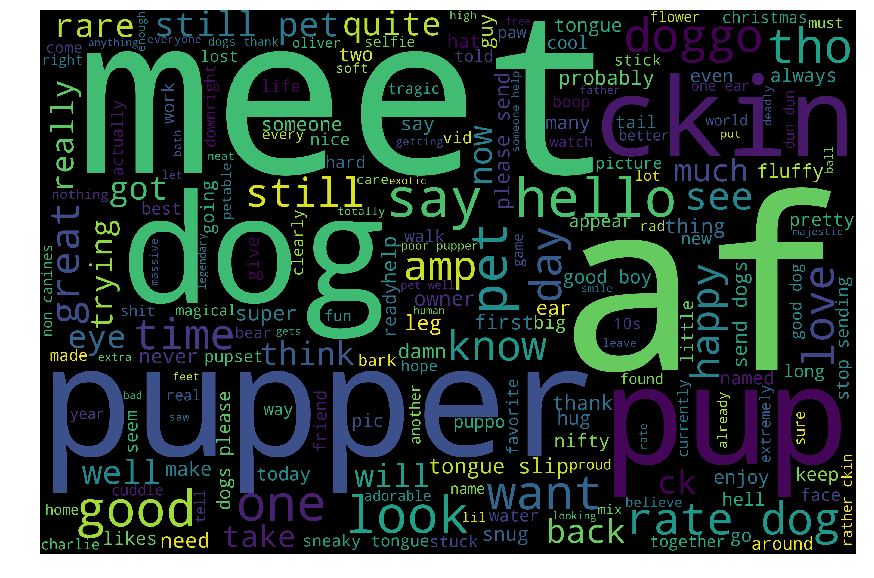

In [18]:
# Reference: 
# [1] https://stackoverflow.com/questions/43606339/generate-word-cloud-from-single-column-pandas-dataframe
# [2] https://www.mikulskibartosz.name/word-cloud-from-a-pandas-data-frame/
wordcloud = WordCloud(width=3000, height=2000).generate(' '.join(df['text']))
plt.figure(figsize=(20,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

#### Exploring the correlation between rating, retweet count & favorite count?

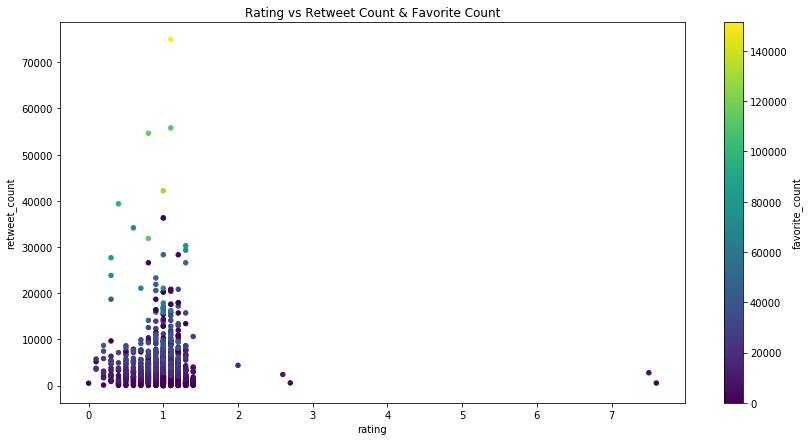

In [295]:
df.plot.scatter(
    x='rating',
    y='retweet_count',
    c='favorite_count',
    colormap='viridis',
    title="Rating vs Retweet Count & Favorite Count",
    figsize=(14,7),
    sharex=False
);

#### Finding The top 10 Popular Dog Name

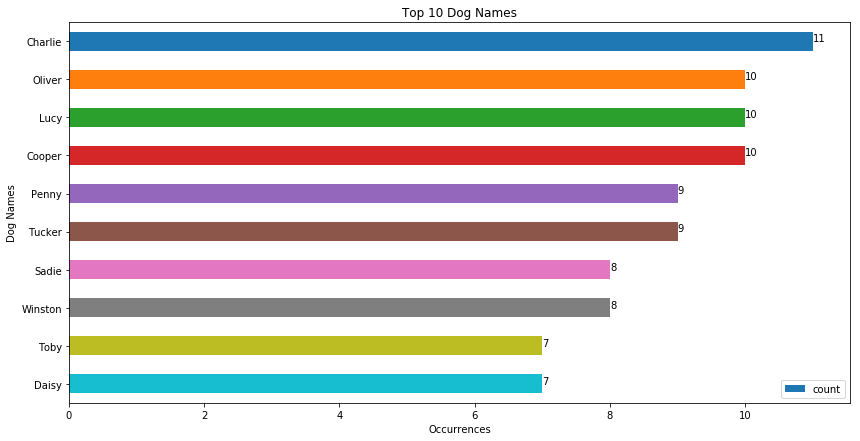

In [104]:
dog_names = df['name'].value_counts().rename_axis('names').reset_index(name='count')
dog_names = dog_names[:10]
dog_names.plot.barh(x='names', y='count', rot=0, figsize=(14,7))
plt.title('Top 10 Dog Names')
plt.xlabel('Occurrences')
plt.ylabel('Dog Names')
plt.gca().invert_yaxis() # Order the chart in descending order.

for index, value in enumerate(y):
    plt.text(value, index, str(value))

plt.show()

In [106]:
df.query('name == "Charlie"')

,tweet_id,timestamp,text,name,rating,dog_stage,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog,retweet_count,favorite_count
210,681891461017812993,2015-12-29 17:36:07,say hello to charlie. he's scholarly af. quite...,Charlie,1.0,pupper,https://pbs.twimg.com/media/CXaQqGbWMAAKEgN.jpg,1,Chihuahua,0.203570,True,Doormat,0.134316,False,Toy Terrier,0.084482,True,3932,14175
458,844580511645339650,2017-03-22 16:04:20,this is charlie. he wants to know if you have ...,Charlie,1.1,doggo,https://pbs.twimg.com/media/C7iNfq1W0AAcbsR.jpg,1,Washer,0.903064,False,Dishwasher,0.032489,False,Printer,0.016456,False,2409,5883
463,842846295480000512,2017-03-17 21:13:10,this is charlie. he's wishing you a very fun a...,Charlie,1.3,doggo,https://pbs.twimg.com/media/C7JkO0rX0AErh7X.jpg,1,Labrador Retriever,0.461076,True,Golden Retriever,0.154946,True,Chihuahua,0.110249,True,488,1596
502,833826103416520705,2017-02-20 23:50:09,meet charlie. she asked u to change the channe...,Charlie,1.3,doggo,https://pbs.twimg.com/media/C5JYaYoVYAAcEQw.jpg,1,Chihuahua,0.438054,True,Kelpie,0.149706,True,Pembroke,0.096480,True,188,1032
508,832369877331693569,2017-02-16 23:23:38,this is charlie. he fell asleep on a heating v...,Charlie,1.1,doggo,https://pbs.twimg.com/media/C40r_GDWAAA5vNJ.jpg,1,Kelpie,0.504690,True,German Short-Haired Pointer,0.105208,True,Staffordshire Bullterrier,0.054338,True,4690,12138
534,827199976799354881,2017-02-02 17:00:17,this is charlie. he wins every game of chess h...,Charlie,1.3,doggo,https://pbs.twimg.com/media/C3rN-lcWEAA9CmR.jpg,4,Great Dane,0.869681,True,American Staffordshire Terrier,0.026658,True,Boxer,0.019866,True,401,1781
778,771102124360998913,2016-08-31 21:47:27,this is charlie. he works for @todayshow. supe...,Charlie,1.2,doggo,https://pbs.twimg.com/media/CrOBSfgXgAABsTE.jpg,1,Labrador Retriever,0.568789,True,Pug,0.179918,True,Staffordshire Bullterrier,0.034437,True,360,1405
861,754011816964026368,2016-07-15 17:56:40,this is charlie. he pouts until he gets to go ...,Charlie,1.2,doggo,https://pbs.twimg.com/media/CnbJuPoXEAAjcVF.jpg,1,French Bulldog,0.600985,True,Boston Bull,0.273176,True,Boxer,0.056772,True,649,2510
1154,703382836347330562,2016-02-27 00:55:11,this is charlie. he's a west side niddlewog. m...,Charlie,1.2,doggo,https://pbs.twimg.com/media/CcLq7ipW4AArSGZ.jpg,2,Golden Retriever,0.945664,True,Standard Poodle,0.014392,True,Tibetan Mastiff,0.012022,True,3451,7690
1214,697255105972801536,2016-02-10 03:05:46,meet charlie. he likes to kiss all the big mil...,Charlie,1.0,doggo,https://pbs.twimg.com/media/Ca0lzzmWwAA5u56.jpg,1,Great Dane,0.173989,True,Malinois,0.165888,True,Doberman,0.119890,True,3513,11864
